# Gathering EXFOR data
In this tutorial we will walk through the parsing and querying of EXFOR for angular distributions (e.g. differential cross sections and analyzing powers), with special attention paid to handling edge cases in how the data is represented, and curating a data set from multiple experiments, accounting for outliers.

The goal will be to query Exfor for a specific type of reaction data, specifically angular distributions, and parse them into `AngularDistributionSysStatErr` objects, which separate statistical and systematic errors. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from exfor_tools import ExforEntry, quantities, reaction

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


## Demonstration of data retrieval and plotting for various reactions and quantities

First let's try to read in $(p,p)$ data from entry C0624:

In [3]:
entry_pp = ExforEntry(
    reaction=reaction.ElasticReaction(
        target=reaction.Nucleus(48, 20),
        projectile=reaction.Nucleus(1, 1),
    ),
    entry="C0624",
    quantity="dXS/dA",
    vocal=True,
)

Found subentry C0624005 with the following columns:
['EN-ERR', 'ERR-SYS', 'ERR-7', 'ERR-9', 'EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Failed to parse subentry C0624005:
	Ambiguous statistical error labels:
ERR-SYS, ERR-7, ERR-9, DATA-ERR


## It failed. What gives? 

`exfor_tools` will try to guess how to parse a subentry based on the column labels. Notice the error message provided by `exfor_tools`: ambiguous error labels. This means we couldn't automatically figure out what the labels mean, and we'll have to manually provide some more information.

Let's take a look at the ERR-ANALYSIS section of that entry and see if we can make sense of these column labels:




In [4]:
print(entry_pp.err_analysis)
print(entry_pp.failed_parses["C0624"][1])

ERR-ANALYS (DATA-ERR) Relative uncertainty.
           (ERR-S,,1.) Statistical uncertainty <1%.
            Systematic uncertainties:
           (ERR-1,,1.) Dead time correction                 <1.0%
           (ERR-2,,0.1)  Correction for reaction losses
                                                 in NaI(Tl) <0.1%
           (ERR-3,,0.3)  Finite geometry correction         <0.3%
           (ERR-4,,1.)  Detector angle                      <1.0%
           (ERR-5,,1.5)  Incident proton energy             <1.5%
           (ERR-6,,2.)  Impurity subtraction - worst case    2.0%
           (ERR-SYS) Uncertainty in the absolute scale includes:
           (ERR-7) Uncertainty in the detector solid angle
           (ERR-8,,1.) Uncertainty in the target rotation angle
           (ERR-9) Uncertainty in the beam current integration
            * Uncertainty in the target thickness
Ambiguous statistical error labels:
ERR-SYS, ERR-7, ERR-9, DATA-ERR



Ok, it looks like `DATA-ERR` does not include systematic uncertainties in the normalization, or absolute scale (e.g. it includes `ERR-1` through `6`, but not `7` though `9` which are lumped under `ERR-SYS`). What we can do is parse this measurement, explicitly specifying that `DATA-ERR` is our only source of statistical uncertainty and `ERR-SYS` is our only source of systematic uncertainty:

In [5]:
entry_pp = ExforEntry(
    entry="C0624",
    reaction=reaction.ElasticReaction(
        target=reaction.Nucleus(48, 20),
        projectile=reaction.Nucleus(1, 1),
    ),
    quantity="dXS/dA",
    vocal=True,
    parsing_kwargs={
        "statistical_err_labels": ["DATA-ERR"],
        "systematic_err_labels": ["ERR-SYS"],
    },
)

Found subentry C0624005 with the following columns:
['EN-ERR', 'ERR-SYS', 'ERR-7', 'ERR-9', 'EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']


Look at that, worked like a charm! Let's check the [entry](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=125555&&sub=C0624&plus=1) to make sure we parsed the errors correctly:

In [6]:
print(
    ", ".join(
        [
            f"{x:1.1f}%"
            for x in 100
            * entry_pp.measurements[0].statistical_err
            / entry_pp.measurements[0].y
        ][:7]
    ),
    "...",
)

3.0%, 3.2%, 1.9%, 1.4%, 1.3%, 2.8%, 1.9% ...


In [7]:
print(f"{100*entry_pp.measurements[0].systematic_norm_err:1.1f}%")

3.0%


In [8]:
entry_pp.measurements[0].systematic_offset_err

0.0

Nice!

### Now let's grab some neutron data

In [9]:
entry_nn = ExforEntry(
    entry="14303",
    reaction=reaction.ElasticReaction(
        target=reaction.Nucleus(48, 20), projectile=reaction.Nucleus(1, 0)
    ),
    quantity="dXS/dA",
    vocal=True,
)

Found subentry 14303004 with the following columns:
['EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry 14303005 with the following columns:
['EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']


Now let's plot all this data:

In [10]:
label_settings = {
    "label_xloc_deg": None,
    "label_offset_factor": 0.1,
    "label_energy_err": False,
    "label_offset": True,
    "label_incident_energy": True,
    "label_excitation_energy": False,
    "label_exfor": False,
}

(0.0001, 1000000000.0)

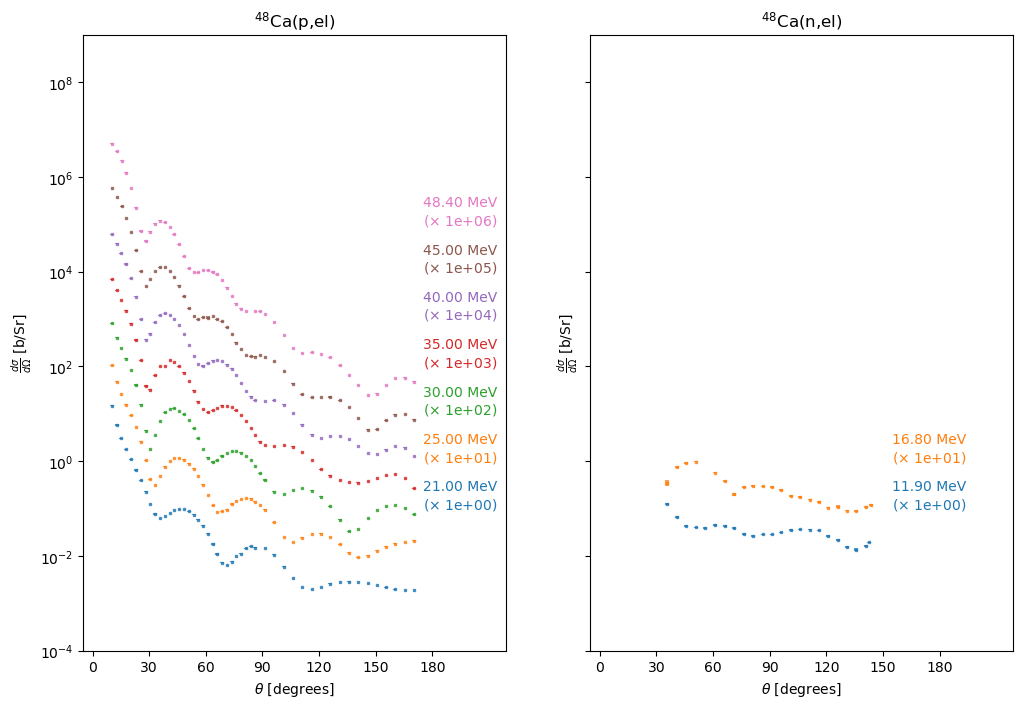

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
entry_pp.plot(
    ax1,
    offsets=10,
    label_kwargs=label_settings,
)
entry_nn.plot(
    ax2,
    offsets=10,
    label_kwargs=label_settings,
)
ax1.set_xlim([-5, 219])
ax2.set_xlim([-5, 219])
ax1.set_ylim([1e-4, 1e9])

### That's pretty, but I can't really see the uncertainties? What gives?

They're there. Let's zoom in our y axis a bit:

(0.2, 10)

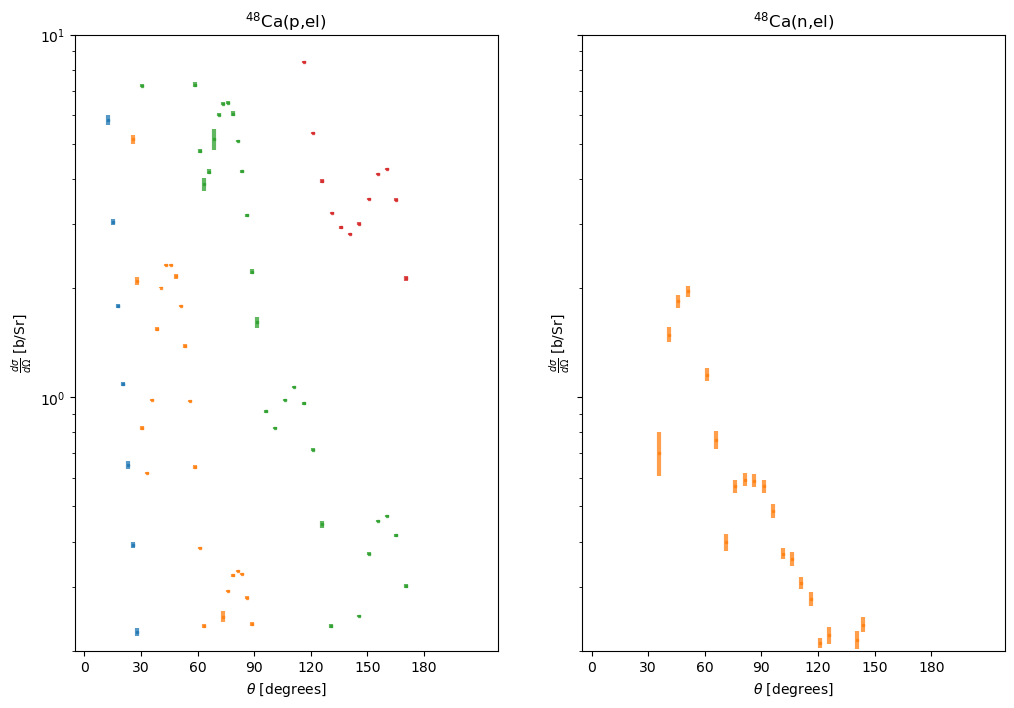

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
entry_pp.plot(
    ax1,
    offsets=20,
    label_kwargs=None,
)
entry_nn.plot(
    ax2,
    offsets=20,
    label_kwargs=None,
)
ax1.set_xlim([-5, 219])
ax2.set_xlim([-5, 219])
ax1.set_ylim([2e-1, 10])

## Nice, let's look at some other data types.

In [13]:
entry_pp_Ay = ExforEntry(
    entry="O0239",
    reaction=entry_pp.reaction,
    quantity="Ay",
    vocal=True,
)

Found subentry O0239015 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']
Found subentry O0239017 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']
Found subentry O0239019 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']


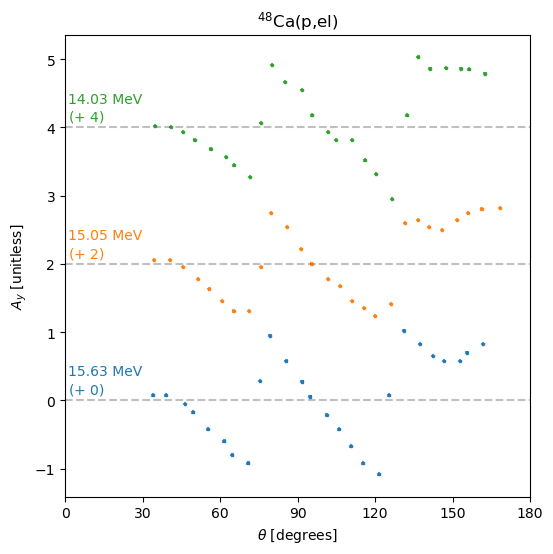

In [14]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

entry_pp_Ay.plot(
    ax,
    offsets=2,
    log=False,
    draw_baseline=True,
    label_kwargs={
        "label_xloc_deg": None,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": True,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": False,
    },
)

In [15]:
entry_pp_ratio = ExforEntry(
    entry="O0239",
    reaction=entry_pp.reaction,
    quantity="dXS/dRuth",
    vocal=True,
)

Found subentry O0239014 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0239016 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0239018 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']


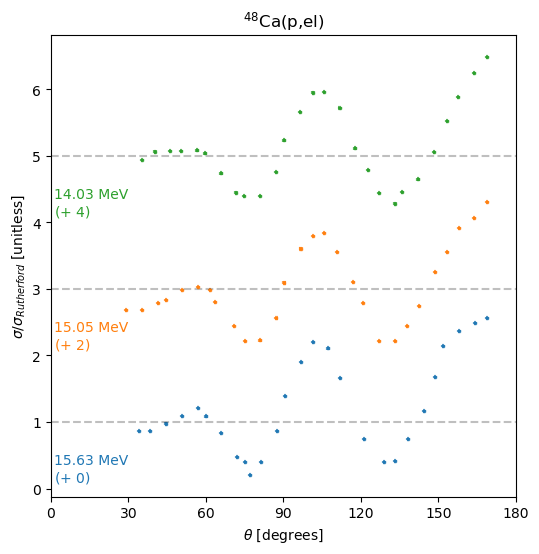

In [16]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

entry_pp_ratio.plot(
    ax,
    offsets=2,
    log=False,
    draw_baseline=True,
    baseline_offset=1,
    label_kwargs={
        "label_xloc_deg": 1,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": True,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": False,
    },
)

## What about reaction channels outside of elastic nucleon-nucleus scattering?

The `Reaction` class supports any A + a -> b + B type reaction, including the the general Exfor processes 'TOT', 'EL', 'INL', 'ABS' or 'X'.

In [17]:
# notice we can just use tuples
ca48_pn = reaction.Reaction(
    target=(48, 20),
    projectile=(1, 1),
    product=(1, 0),
    residual=(48, 21),
)
print(
    ca48_pn.Q
)  # just the ground state to ground state Q-value, not the Coulomb displacement energy

-0.5031320000014148


In [18]:
entry_pn = ExforEntry(
    entry="O0178",
    reaction=ca48_pn,
    quantity="dXS/dA",
    vocal=True,
)

Found subentry O0178006 with the following columns:
['ERR-1', 'ERR-2', 'ERR-3', 'ERR-4', 'EN', 'Q-VAL', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA', 'ERR-T']
Failed to parse subentry O0178006:
	Ambiguous statistical error labels:
ERR-1, ERR-2, ERR-3, ERR-4, DATA-ERR, ERR-T
Found subentry O0178007 with the following columns:
['ERR-1', 'ERR-2', 'ERR-3', 'ERR-4', 'EN', 'Q-VAL', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA', 'ERR-T']
Failed to parse subentry O0178007:
	Ambiguous statistical error labels:
ERR-1, ERR-2, ERR-3, ERR-4, DATA-ERR, ERR-T
Found subentry O0178008 with the following columns:
['ERR-1', 'ERR-2', 'ERR-3', 'ERR-4', 'EN', 'Q-VAL', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']
Failed to parse subentry O0178008:
	Ambiguous statistical error labels:
ERR-1, ERR-2, ERR-3, ERR-4, DATA-ERR


In [19]:
print(entry_pn.err_analysis)

ERR-ANALYS The Error Bars Displayed on the Data in Fig.3
           Represent Relative Errors Within Each Angular
           Distribution Which Result From Statistical
           Uncertainties in the Peak Fitting Combined
           Independently With 2% Fluctuations in the Product of
           Beam Charge and Target Thickness.
           1.The Errors in the Absolute Magnitudes of the Cross
           Sections Due to Uncertainties in the Neutron Detection
           Efficiency Calculations Are Estimated to be About 10%.
           (ERR-1).See 1.
           (ERR-2).Error in the Target Thickness is Less Than 5%.
           (ERR-3).Error in the Beam Current Integration Less 5%.
           (ERR-4).Neutron Attenuation Along the Flight Path.


In [20]:
entry_pn = ExforEntry(
    entry="O0178",
    reaction=ca48_pn,
    quantity="dXS/dA",
    vocal=True,
    parsing_kwargs={
        "statistical_err_labels": ["DATA-ERR"],
        "systematic_err_labels": ["ERR-1"],
    },
)

Found subentry O0178006 with the following columns:
['ERR-1', 'ERR-2', 'ERR-3', 'ERR-4', 'EN', 'Q-VAL', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA', 'ERR-T']
Found subentry O0178007 with the following columns:
['ERR-1', 'ERR-2', 'ERR-3', 'ERR-4', 'EN', 'Q-VAL', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA', 'ERR-T']
Found subentry O0178008 with the following columns:
['ERR-1', 'ERR-2', 'ERR-3', 'ERR-4', 'EN', 'Q-VAL', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']


Text(0.5, 1.0, '$^{48}$Ca(p,n)$^{48}$Sc$_\\text{IAS}$')

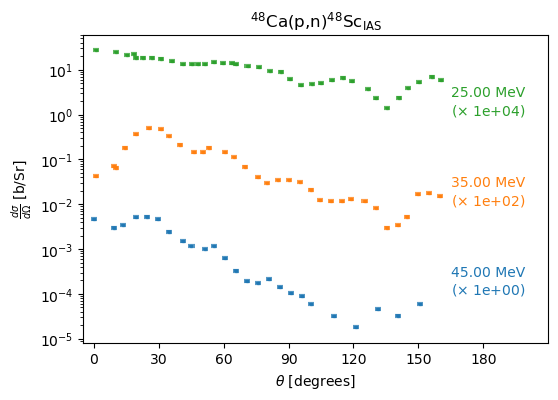

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
entry_pn.plot(
    ax, offsets=100, label_kwargs={"label_xloc_deg": 165, "label_offset_factor": 0.0001}
)
ax.set_xlim([-5, 210])
ax.set_title(ax.title.get_text() + r"$_\text{IAS}$")

## Querying for multiple entries
Let's figure out how to query EXFOR for multiple entries and plot them all

In [22]:
from exfor_tools import curate

In [23]:
rxn = reaction.ElasticReaction(
    target=reaction.Nucleus(208, 82),
    projectile=reaction.Nucleus(1, 1),
)

In [24]:
# by the way, we store the mass and Fermi energies of our reactants:
print(rxn.target.m0)
print(rxn.target.Efn)
print(rxn.Q)  # of course this must be 0 as this is elastic

193687.12278341982
-5.652699393845978
0


In [25]:
entries, failed_parses = curate.query_for_entries(
    reaction=rxn,
    quantity="dXS/dA",
    Einc_range=[10, 100],
    vocal=True,
)
print(f"\nFound {len(entries.keys())} entries")
print(f"\nFailed to parse {len(failed_parses.keys())} entries")

Found subentry C0893042 with the following columns:
['EN', 'ANG-CM', 'DATA-CM', 'ERR-S']
Found subentry E1201014 with the following columns:
['EN', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry E1846023 with the following columns:
['EN-RSL', 'E-RSL', 'E-LVL-ERR', 'EN', 'ANG-CM', 'DATA-CM']
Found subentry O0032025 with the following columns:
['EN', 'ANG-CM', 'DATA', 'ERR-S']
Found subentry O0142011 with the following columns:
['EN', 'ERR-1', 'ANG-CM', 'DATA-CM', 'ERR-T']
Failed to parse subentry O0142011:
	Ambiguous statistical error labels:
ERR-1, ERR-T
Found subentry O0157004 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0166023 with the following columns:
['EN', 'ANG-ERR-D', 'ERR-DIG', 'ANG-CM', 'DATA']
Found subentry O0208009 with the following columns:
['EN', 'ERR-1', 'ANG-ERR', 'ANG-CM', 'DATA-CM', 'ERR-2']
Failed to parse subentry O0208009:
	Ambiguous statistical error labels:
ERR-1, ERR-2
Found subentry O0211017 with the followi

### Let's handle these failed parses by manually adding them to `entries`
This will require going and reading the `ERR-ANALYSIS` part of the common section of each entry.

In [26]:
for k, v in failed_parses.items():
    print(f"Entry: {k}")
    print(v.failed_parses[k][1])

Entry: O0142
Ambiguous statistical error labels:
ERR-1, ERR-T
Entry: O0208
Ambiguous statistical error labels:
ERR-1, ERR-2
Entry: T0101
Ambiguous statistical error labels:
DATA-ERR1, DATA-ERR


In [27]:
entries["O0142"] = ExforEntry(
    entry="O0142",
    reaction=rxn,
    quantity="dXS/dA",
    Einc_range=[10, 100],
    vocal=True,
    parsing_kwargs={
        "statistical_err_labels": ["ERR-T"],
        "systematic_err_labels": ["ERR-1"],
    },
)

entries["O0208"] = ExforEntry(
    entry="O0208",
    reaction=rxn,
    quantity="dXS/dA",
    Einc_range=[10, 100],
    vocal=True,
    parsing_kwargs={
        "statistical_err_labels": ["ERR-2"],
        "systematic_err_labels": ["ERR-1"],
    },
)

entries["T0101"] = ExforEntry(
    entry="T0101",
    reaction=rxn,
    Einc_range=[10, 100],
    quantity="dXS/dA",
    vocal=True,
    parsing_kwargs={
        "statistical_err_labels": ["DATA-ERR"],
        "systematic_err_labels": ["DATA-ERR1"],
    },
)

Found subentry O0142011 with the following columns:
['EN', 'ERR-1', 'ANG-CM', 'DATA-CM', 'ERR-T']
Found subentry O0208009 with the following columns:
['EN', 'ERR-1', 'ANG-ERR', 'ANG-CM', 'DATA-CM', 'ERR-2']
Found subentry T0101004 with the following columns:
['DATA-ERR1', 'EN', 'ANG-CM', 'DATA-CM', 'DATA-ERR']


# That was easy!
Now, let's plot measurements from all of those entries on the same figure

In [31]:
from exfor_tools.distribution import AngularDistribution

In [32]:
measurements_categorized = curate.categorize_measurements_by_energy(entries)

(0.0, 220.0)

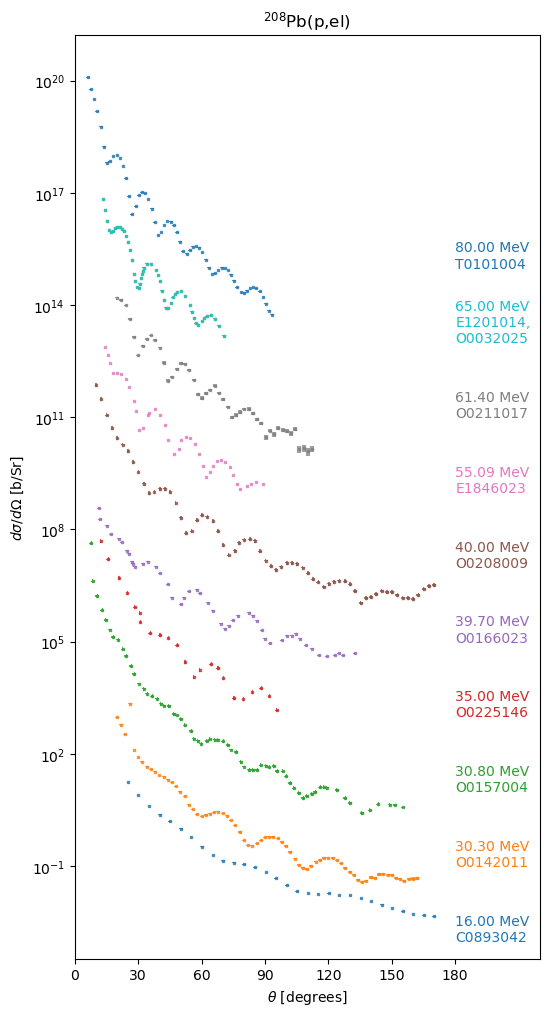

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
AngularDistribution.plot(
    measurements_categorized,
    ax,
    offsets=100,
    data_symbol=r"$d\sigma/d\Omega$",
    rxn_label=list(entries.values())[0].reaction.reaction_latex,
    label_kwargs={
        "label_xloc_deg": 180,
        "label_offset_factor": 0.001,
        "label_energy_err": False,
        "label_offset": False,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": True,
    },
)
ax.set_xlim([0, 220])

## Handling outliers and other issues
- EXFOR subentries E1201014 and O0032025 are duplicates
- The subentry [O0142011](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=123189&&sub=O0142&plus=1) has an outlier (the 4th point). Looking at the data, it is exactly 10 times what it would be expected. It is likely this is the result of transcription error. 

Let's fix these and plot again,

In [38]:
del entries["E1201"]

In [39]:
print(entries["O0142"].measurements[0].y[:10])

[ 9.539   6.037   3.374  21.561   1.264   0.8222  0.6223  0.4491  0.3806
  0.3291]


In [40]:
entries["O0142"].measurements[0].y[3] *= 0.1
entries["O0142"].measurements[0].y_err[3] *= 0.1
entries["O0142"].measurements[
    0
].notes = "Divided 4th point by 10"  #  so we can keep track

This seems like a good time to explain the argument `Einc_tol`. This parameter is an energy in MeV. If two data sets at two incident energies are within `Einc_tol` of eachother, `categorize_measurements_by_energy` treats them as part of the same category.

## Now let's plot our final data set

In [41]:
measurements_categorized = curate.categorize_measurements_by_energy(
    entries, Einc_tol=0.1
)

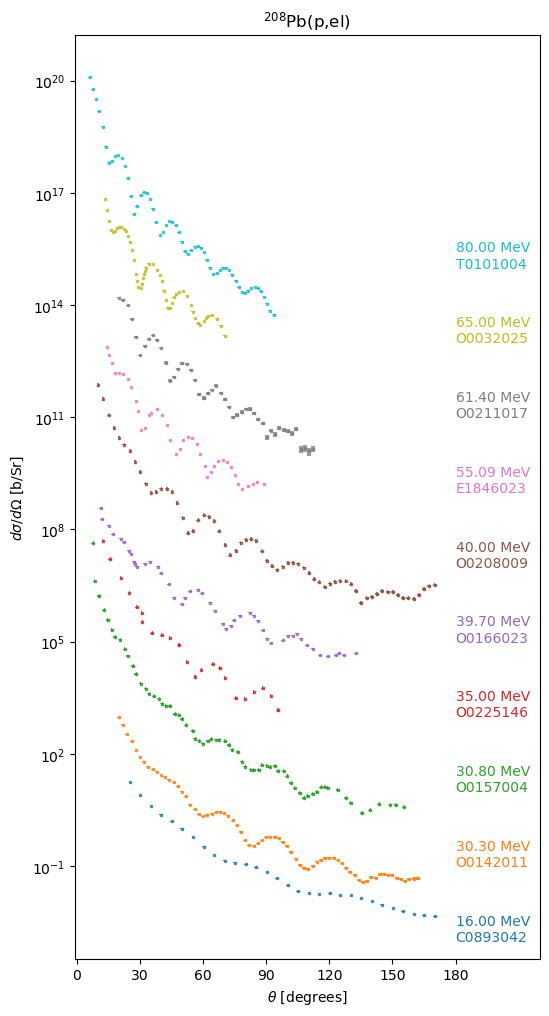

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
AngularDistribution.plot(
    measurements_categorized,
    ax,
    offsets=100,
    data_symbol=r"$d\sigma/d\Omega$",
    rxn_label=list(entries.values())[0].reaction.reaction_latex,
    label_kwargs={
        "label_xloc_deg": 180,
        "label_offset_factor": 0.001,
        "label_energy_err": False,
        "label_offset": False,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": True,
    },
)
ax.set_xlim([-1, 220])

plt.savefig("lead_208_pp_dxds.png")